# Make forward model (Y) with AVISO data

In [1]:
import numpy as np
import scipy
import xarray as xr
import cmocean as cmo
import matplotlib.pyplot as plt
from aviso_rossby_wave import skill_matrix, reverse_vector, build_h_matrix
from aviso_rossby_wave import forecast_ssh, inversion

## Starting Date

In [2]:
day0, day1 = 0, 1 
time_range = 30 #(day1 - day0) * 3 + 1  # forecast time range
exp = 1 # R_over_P = K^-1

### Stratification paramters

## Subset 10 degree by 10 degree of ocean
### the aviso data is sampled at 5-day intervals

In [3]:
lonidx_west, lonidx_east = 60, 100
#lonidx_west, lonidx_east = 50, 100   # use asymmetric domain for debugging
latidx_south, latidx_north = 34, 74

In [4]:
avisso_ds = xr.open_dataset('./aviso_msla_ccs_5d.nc')
SSHA = avisso_ds.msla[latidx_south:latidx_north, lonidx_west:lonidx_east, :]
T_time = avisso_ds.time.data[day0:] * 86400 # in seconds

In [5]:
date_time = avisso_ds.date_time.data[day0:]
date_time[0]

numpy.datetime64('2016-06-01T00:00:00.000000000')

In [6]:
ssha_time_mean = SSHA[:].mean(axis = -1)
#ssha_time_mean = SSHA[:, :, day0 : day0 + 30].mean(axis = -1) # remove 150-day mean insead of multi-year mean (climatology)

In [7]:
SSHA = SSHA - ssha_time_mean # remove 150-day mean  SSHA[day0 + day0 + 30].mean(axis = -1) 
SSHA_masked = np.ma.masked_invalid(SSHA)
ssha_mask = np.ma.getmask(SSHA_masked)

#### MSLA is the AVISO SSH anomalies to fit
#### Fit multiple days of SSH anomalies: day0 to day1

In [8]:
MSLA0 = SSHA_masked[:, :, day0:day1] #AVISO input 

In [9]:
lon, lat = (360 - avisso_ds.lon[lonidx_west:lonidx_east].data) * -1, avisso_ds.lat[latidx_south:latidx_north].data
# lon, lat = (360 - avisso_ds.lon.data) * -1, avisso_ds.lat.data

In [10]:
dlon = lon - lon.mean()
dlat = lat - lat.mean()

In [11]:
SSH0 = avisso_ds.msla[:, :, day0]
SSHA0 = SSH0 - avisso_ds.msla[:].mean(axis = -1) # avisso_ds.msla[:, :, day0: day0 + 30].mean(axis = -1)

In [12]:
# plt.figure(figsize = (6, 5))
# # plt.subplot(121)
# # plt.title('a) SSH Anomalies, ' + str(date_time[0])[:10], fontsize = 14)
# plt.pcolor((360 - avisso_ds.lon[30:140]) * -1, avisso_ds.lat, 
#            SSHA0[:, 30:140], vmin = -0.15, vmax = .15, cmap = cmo.cm.balance)
# plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
# plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)

# import matplotlib.patches as mpatches

# left, bottom, width, height = (lon[0], lat[0],
#                                lon[-1] - lon[0],
#                                lat[-1]- lat[0])
# rect=mpatches.Rectangle((left,bottom),width,height, #latidx_south:latidx_north, 
#                         fill=False,
#                         color="black",
#                        linewidth=2)
#                        #facecolor="red")
# plt.gca().add_patch(rect)
# plt.colorbar()

# # plt.subplot(122)
# # plt.title('b) SSH Anomalies, ' + str(date_time[0])[:10], fontsize = 14)
# # plt.pcolor(lon, lat, SSHA[:, :, day0], vmin = -0.2, vmax = .2, cmap = cmo.cm.balance)
# # plt.colorbar()
# # plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
# # plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
# plt.savefig('AVISO_SSHA_10deg'+ str(date_time[0])[:10]  +'.png')

### parameters

In [13]:
Phi0 = lat.mean() # central latitude (φ0)
Omega = 7.27e-5 # Ω is the angular speed of the earth
Earth_radius = 6.371e6 / 1e5 # meters
Beta = 2 * Omega * np.cos(Phi0) / Earth_radius
f0 =  2 * Omega * np.sin(Phi0) #1.0313e-4 

#### Rossby wave vertical modes

In [14]:
MModes = 1

#### define wavenumber interval based on domain size

In [15]:
L_lat = 10 # domain latitude length degree 
L_lon = 10 # domain lognitude length

domain_factor = 1.1 # the smaller, the less waves

k_interval = 2 * np.pi / (domain_factor * L_lon) # zonal wavemenumber interval
l_interval = 2 * np.pi / (domain_factor * L_lat) # meridional wavemenumber interval

lamda_min = 1.2 # 100km = 1 degree minimum wavelength resolved , the smaller, the more waves

k_min = 0
k_max = 2 * np.pi / lamda_min
l_max = k_max
l_min = -1 * l_max

In [16]:
k_n_orig = np.arange(k_min, k_max, k_interval) # degree^-1
l_n_orig = np.arange(l_min, l_max, l_interval) # degree^-1
k_n = k_n_orig.reshape(len(k_n_orig), MModes) #* 0 # lon, zonal propagration 
l_n = l_n_orig.reshape(len(l_n_orig), MModes) #* 0 # lat, meridonal propagration

In [17]:
strat_ds = xr.open_dataset('./stratification_sample_ccs.nc')

#### Wavespeed and Rossby wave deformation radius

In [18]:
Psi = strat_ds.Psi.data
Rm = 5e4  / 1e5 # 50 km to degree
wavespeed = Rm * f0  # deg / s strat_ds.C2[:MModes].data
Rm = np.array([Rm]) #unit: degree 
wavespeed, Rm , np.sqrt(strat_ds.C2[:MModes].data)/1e5 # deg/s

(2.1545995672172316e-05, array([0.5]), array([2.85035991e-05]))

In [19]:
MSLA0.shape, k_n.shape, l_n.shape, lon.shape, lat.shape

((40, 40, 1), (10, 1), (19, 1), (40,), (40,))

#### evalucate the skill of each wave

In [20]:
skill, SSHA_vector, Iindex, Jindex, Tindex = skill_matrix(MSLA0, Psi, k_n, l_n, MModes, Rm, lon, lat, T_time)

#### Number of models/waves

In [21]:
M = l_n.size * k_n.size

In [22]:
MSLA0[0:5,0:5]

masked_array(
  data=[[[0.008853332285458843],
         [0.02947666815637301],
         [0.04761000220896676],
         [0.0553093306752271],
         [0.05035133087697129]],

        [[-0.013955331827261636],
         [0.007025336112516628],
         [0.02831000160969173],
         [0.03988400434609503],
         [0.039753999842214394]],

        [[-0.048724665488116436],
         [-0.038676001106699304],
         [-0.020184666117032374],
         [-0.002307996462332082],
         [0.009437333538662648]],

        [[-0.07513400008213163],
         [-0.07373800063971431],
         [-0.05934733353312671],
         [-0.03874266599149753],
         [-0.01939133060232659]],

        [[-0.08465199975820724],
         [-0.08507333302055485],
         [-0.07292533353475543],
         [-0.055183999499616526],
         [-0.03866399988221625]]],
  mask=[[[False],
         [False],
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
      

In [23]:
kk, ll = np.meshgrid(k_n, l_n)

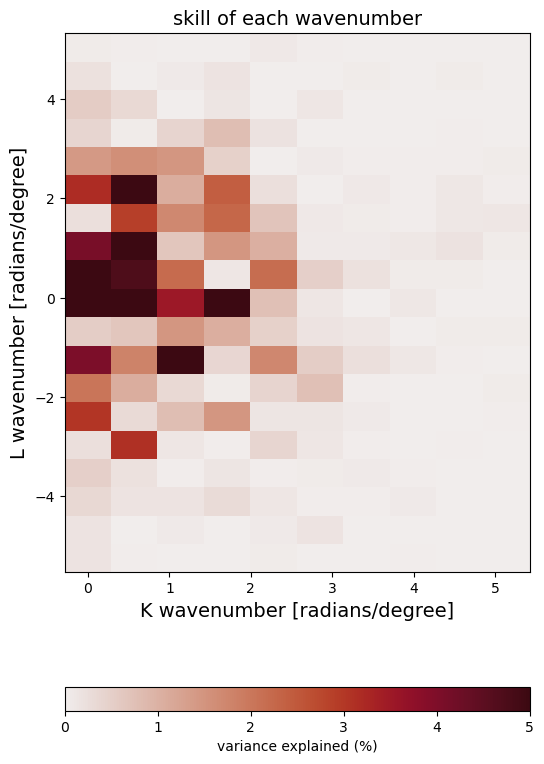

In [24]:
plt.figure(figsize = (6, 10))
plt.pcolor(kk,ll, skill[:, :, 0].T * 100, cmap = cmo.cm.amp, vmin = 0, vmax = 5)
#plt.pcolor(kk,ll,skill[:,:, 0].T * 100, cmap = cmo.cm.amp, vmin = 0, vmax = 5)
plt.xlabel('K wavenumber [radians/degree]', fontsize = 14)
plt.ylabel('L wavenumber [radians/degree]', fontsize = 14)
plt.colorbar(orientation = 'horizontal', label = 'variance explained (%)')
plt.title('skill of each wavenumber', fontsize = 14)
plt.savefig('./skill_matrix_AVISO.png')
plt.savefig('./AVISO_skill_matrix_' + str(M) + '.png')

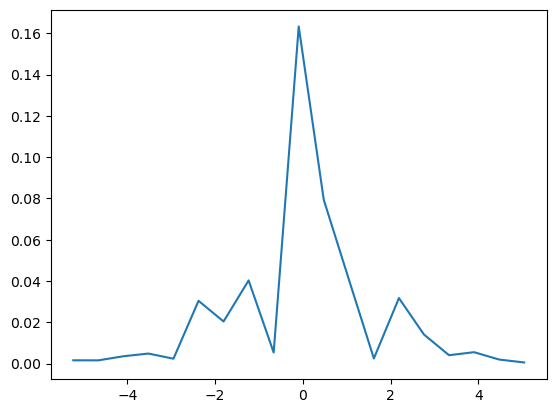

In [25]:
plt.plot(l_n[:],skill[0,:])

#### Signal to noise ratio matrix

In [26]:
counter = 0
exp = -2
ssh_std = .1
k0 = k_n.max() # flat at or below k0 

p_diagonal = np.zeros([2 * M])
kl, kl_plot = np.zeros(M), np.zeros(2*M)
k_, l_ = np.zeros(len(k_n)*len(l_n)), np.zeros(len(k_n)*len(l_n))
counter = 0
R = 0.01 # noise = 1. cm

for kk in k_n:
    for ll in l_n:
        k_[counter] , l_[counter]  = kk, ll
        kl[counter] =  np.sqrt(kk ** 2 + ll ** 2) # wavenumber
        kl_plot[2 * counter], kl_plot[2 * counter + 1] = kl[counter], kl[counter]
        p_diagonal[2 * counter] = (kl[counter]+k0) ** exp 
        p_diagonal[2 * counter + 1] = (kl[counter]+k0) ** exp 
        counter += 1   

P_matrix = np.zeros([2 * M, 2 * M])
p_factor = .16/p_diagonal.sum() # variance of the model,  convert sum of variance from waven number to meter
np.fill_diagonal(P_matrix[:],  R / p_diagonal / p_factor)

/var/folders/tb/ynf00vf51q52gx0ngbt970v00000gn/T/ipykernel_36914/1449953493.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k_[counter] , l_[counter]  = kk, ll
/var/folders/tb/ynf00vf51q52gx0ngbt970v00000gn/T/ipykernel_36914/1449953493.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kl[counter] =  np.sqrt(kk ** 2 + ll ** 2) # wavenumber


In [27]:
H_all = build_h_matrix(MSLA0, MModes, k_n, l_n, lon, lat, T_time[day0:], Psi, Rm, day0)

In [28]:
dlon = lon - lon.mean()
dlat = lat - lat.mean()
    
H_cos, H_sin = np.zeros([len(SSHA_vector), M]), np.zeros([len(SSHA_vector), M])
H_all1 = np.zeros([len(SSHA_vector), M * 2])
omega = np.zeros([len(k_n), len(l_n), MModes])

nn = 0 
for kk in range(len(k_n)):
    for ll in range(len(l_n)):
        for mm in range(MModes):
            omega[kk, ll, mm] =  -(Beta * k_n[kk, mm]) / (k_n[kk, mm] ** 2 + l_n[ll, mm] ** 2 + Rm ** -2)
            for count in range(len(Iindex)):
                # (data, model)
                H_cos[count, nn] = Psi[0, mm] * np.cos(k_n[kk, mm] * dlon[int(Iindex[count])] + l_n[ll, mm] * dlat[int(Jindex[count])] - omega[kk, ll, mm] * T_time[int(Tindex[count])]) 
                H_sin[count, nn] = Psi[0, mm] * np.sin(k_n[kk, mm] * dlon[int(Iindex[count])] + l_n[ll, mm] * dlat[int(Jindex[count])] - omega[kk, ll, mm] * T_time[int(Tindex[count])])
            nn += 1

H_all1[:, 0::2] = H_cos 
H_all1[:, 1::2] = H_sin

/var/folders/tb/ynf00vf51q52gx0ngbt970v00000gn/T/ipykernel_36914/2108238595.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  omega[kk, ll, mm] =  -(Beta * k_n[kk, mm]) / (k_n[kk, mm] ** 2 + l_n[ll, mm] ** 2 + Rm ** -2)


In [29]:
H_all == H_all1

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [30]:
H_all.shape, H_all1.shape

((1600, 380), (1600, 380))

In [31]:
#plt.pcolor(H_all-H_all1, cmap = cmo.cm.amp)

#### solve for amplitudes

In [32]:
amp, ssh_estimated = inversion(SSHA_vector, H_all1, P_matrix)# P_over_R)

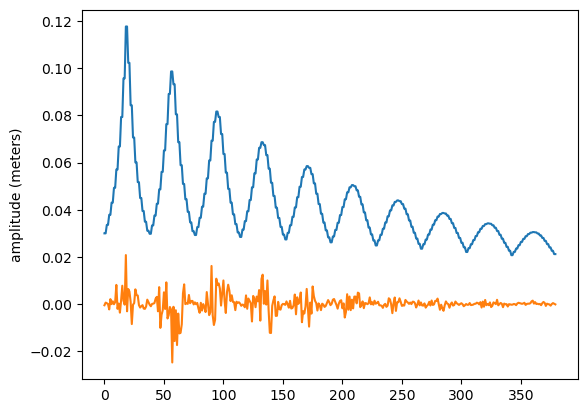

In [33]:
plt.plot(1/P_matrix.diagonal())
plt.ylabel('amplitude (meters)')
plt.plot(amp)

### Fit AVISO data to Rossby wave model

In [34]:
amp.shape, SSHA_masked.shape, np.shape(H_all)

((380,), (40, 40, 150), (1600, 380))

In [ ]:
SSHA_predicted = np.zeros([time_range, MSLA0[:, :, 0:1].size])
SSHA_true = np.zeros([time_range, MSLA0[:, :, 0:1].size])
variance_explained_inverse  = np.zeros([time_range])
MSLA_fwrd = np.zeros([MSLA0.shape[0], MSLA0.shape[1], time_range])
for day in range(time_range):
#for day in range(1):
    # SSH data
    MSLA = SSHA_masked[:, :, day0+day: day0+day+1]
    # Build basis function H matrix
    H_all = build_h_matrix(MSLA, MModes, k_n, l_n, lon, lat, T_time[day0:], Psi, Rm, day0 + day)
    print(H_all.shape, amp.shape, MSLA.shape)
    # forecast SSH
    SSHA_predicted[day], SSHA_true[day], variance_explained_inverse[day] = forecast_ssh(MSLA, amp, H_all)
    # reverse vector
    MSLA_fwrd[:, :, day:day+1] = reverse_vector(MSLA, SSHA_predicted[day])

    if (day < 1):
        plt.figure(figsize = (15, 5))

        plt.subplot(131)
        plt.pcolormesh(lon, lat, MSLA[:, :, 0], cmap = cmo.cm.balance, vmin = -.15, vmax = .15) 
        plt.colorbar()
        plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
        plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
        plt.title('a) AVISO data ' + str(date_time[day])[:10], fontsize = 14)

        plt.subplot(132)
        plt.pcolormesh(lon, lat, MSLA_fwrd[:, :, day], vmin = -.15, vmax = .15, cmap = cmo.cm.balance)
        plt.colorbar()
        plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
        plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
        plt.title('b) Rossby wave model, 450 waves', fontsize = 14)

        residual = MSLA[:, :, 0] - MSLA_fwrd[:, :, day] 
        plt.subplot(133)
        plt.pcolormesh(lon, lat, residual, cmap = cmo.cm.balance, vmin = -.15, vmax = .15)
        plt.colorbar()
        plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
        plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
        plt.title('c) Residual variance ' + str((variance_explained_inverse[day]) * 100)[:4] + '%', fontsize = 14)
        plt.tight_layout()
        plt.savefig('./forward_model/fwrd_ssh_' + str(date_time[day0+day])[:10] +'_' + str(skill.size) + 'waves.png', dpi = 300)
        #plt.close()

In [ ]:
ds_output = xr.Dataset(data_vars={'k_n' : k_n[:, 0],
                                  'l_n' : l_n[:, 0],
                                  'Amplitudes': amp,
                                  'variance_explained': (('time'), 1-variance_explained_inverse),
                                  'MSLA_forward' : (('YC', 'XC', 'time'), MSLA_fwrd[:, :, :time_range]),
                                  'Rm': Rm,
                                  'XC' : (('XC'), lon.data), 
                                  'YC' : (('YC'), lat.data),
                                  'time': date_time[:time_range]},
                      attrs = dict(description=('Data sample of the selected waves, amplitudes, estimated SSH anomalies and residual, fit with ' 
                                                + str(day1 - day0) + '-day prior data.')))

In [ ]:
'residual variance', variance_explained_inverse, date_time[:time_range]

In [ ]:
plt.plot(date_time[:time_range], variance_explained_inverse[:] * 100)
plt.ylabel('residual variance (%)')
plt.title('residual')

In [ ]:
ds_output.to_netcdf('./rossby_wave_estimate_' + str(date_time[0])[:10] +'_' + str(l_n.size * k_n.size) +'waves.nc')
#ds_output.to_netcdf('./rossby_wave_estimate_' + str(date_time[0])[:10] +'_' + str(l_n.size * k_n.size) +'waves_data'+ str(int((day1 - day0)*5)) +'days.nc')

### Plot the Rossby wave model versus the AVISO data

In [ ]:
time = T_time[day0:day0+time_range]/86400

In [ ]:
selected_lat = 28
plt.figure(figsize = (10, 10))     
SSHA_slice= SSHA_masked[selected_lat, :, day0:day0+time_range].T
plt.subplot(311) 
plt.title('a) AVISO SSH Hovmöller plot: Latitude: ' + str(lat[selected_lat]) + '$^\circ$N', fontsize = 12)
plt.pcolormesh(lon, time, SSHA_slice, cmap = cmo.cm.balance, vmin = -.12, vmax = .12)
plt.plot(lon, np.repeat(time[day1 - day0],  len(lon)))
plt.colorbar()
plt.ylabel('time (days)', fontsize = 12)
plt.yticks(time[0::2], time[0::2] - time[0])

plt.subplot(312) 
plt.title('b) Rossby wave Hovmöller plot: Latitude: ' + str(lat[selected_lat]) + '$^\circ$N', fontsize = 12)
plt.pcolormesh(lon, time, MSLA_fwrd[selected_lat, :, :time_range].T, cmap = cmo.cm.balance, vmin = -.12, vmax = .12)
plt.plot(lon, np.repeat(time[day1 - day0], len(lon)))
plt.colorbar()
plt.xlabel('longitude ($^\circ$W)', fontsize = 12)
plt.ylabel('time (days)', fontsize = 12)
plt.yticks(time[0::4], time[0::4] - time[0])

plt.subplot(313) 
plt.title('c) Hovmöller plot difference: Latitude: ' + str(lat[selected_lat]) + '$^\circ$N', fontsize = 12)
plt.pcolormesh(lon, time, SSHA_slice - MSLA_fwrd[selected_lat, :, :time_range].T,cmap = cmo.cm.balance, vmin = -.12, vmax = .12)
plt.plot(lon, np.repeat(time[day1 - day0], len(lon)))
plt.colorbar()
plt.xlabel('longitude ($^\circ$W)', fontsize = 12)
plt.ylabel('time (days)', fontsize = 12)
plt.yticks(time[0::4], time[0::4] - time[0])

plt.tight_layout()
plt.savefig('./hovmoller/Hovmoller' +'_lat_' + str(selected_lat) + '.png', dpi = 300)

In [ ]:
selected_lat = 20
plt.figure(figsize = (10, 10))

SSHA_slice = SSHA_masked[ selected_lat, :, day0:day0+time_range].T
plt.subplot(311) 
plt.title('a) AVISO SSH Hovmöller plot: Latitude: ' + str(lat[selected_lat]) + '$^\circ$N', fontsize = 12)
plt.pcolormesh(lon, time, SSHA_slice, cmap = cmo.cm.balance, vmin = -.12, vmax = .12)
plt.plot(lon, np.repeat(time[day1 - day0], len(lon)))
plt.colorbar()
plt.ylabel('time (days)', fontsize = 12)
plt.yticks(time[0::2], time[0::2] - time[0])


plt.subplot(312) 
plt.title('b) Rossby wave Hovmöller plot: Latitude: ' 
          + str(lat[selected_lat]) + '$^\circ$N', fontsize = 12)
plt.pcolormesh(lon, time, MSLA_fwrd[selected_lat, :, :time_range].T, cmap = cmo.cm.balance, vmin = -.12, vmax = .12)
plt.plot(lon, np.repeat(time[day1 - day0], len(lon)))
plt.colorbar()
plt.xlabel('longitude ($^\circ$W)', fontsize = 12)
plt.ylabel('time (days)', fontsize = 12)
plt.yticks(time[0::4], time[0::4] - time[0])

plt.subplot(313) 
plt.title('c) Hovmöller plot difference: Latitude: ' 
          + str(lat[selected_lat]) + '$^\circ$N', fontsize = 12)
plt.pcolormesh(lon, time, SSHA_slice - MSLA_fwrd[selected_lat, :, :time_range].T,
               cmap = cmo.cm.balance, vmin = -.12, vmax = .12)
plt.plot(lon, np.repeat(time[day1 - day0], len(lon)))
plt.colorbar()
plt.xlabel('longitude ($^\circ$W)', fontsize = 12)
plt.ylabel('time (days)', fontsize = 12)
plt.yticks(time[0::4], time[0::4] - time[0])

plt.tight_layout()
plt.savefig('./hovmoller/Hovmoller' +'_lat_' + str(selected_lat) + '.png', dpi = 300)

In [ ]:
selected_lat = 10
plt.figure(figsize = (10, 10))

plt.subplot(311) 
plt.title('a) AVISO SSH Hovmöller plot: Latitude: ' + str(lat[selected_lat]) + '$^\circ$N', fontsize = 12)
plt.pcolormesh(lon, time,  SSHA_masked[ selected_lat,:, day0:day0+time_range].T, cmap = cmo.cm.balance, vmin = -.12, vmax = .12)
plt.plot(lon, np.repeat(time[day1 - day0], len(lon)))
plt.colorbar()
plt.ylabel('time (days)', fontsize = 12)
plt.yticks(time[0::2], time[0::2] - time[0])


plt.subplot(312) 
plt.title('b) Rossby wave Hovmöller plot: Latitude: ' 
          + str(lat[selected_lat]) + '$^\circ$N', fontsize = 12)
plt.pcolormesh(lon, time, MSLA_fwrd[ selected_lat, :, :time_range].T, cmap = cmo.cm.balance, vmin = -.12, vmax = .12)
plt.plot(lon, np.repeat(time[day1 - day0], len(lon)))
plt.colorbar()
plt.xlabel('longitude ($^\circ$W)', fontsize = 12)
plt.ylabel('time (days)', fontsize = 12)
plt.yticks(time[0::4], time[0::4] - time[0])

plt.subplot(313) 
plt.title('c) Hovmöller plot difference: Latitude: ' 
          + str(lat[selected_lat]) + '$^\circ$N', fontsize = 12)
plt.pcolormesh(lon, time, SSHA_masked[ selected_lat, :, day0:day0+time_range].T - MSLA_fwrd[selected_lat, :, :time_range].T,
               cmap = cmo.cm.balance, vmin = -.12, vmax = .12)
plt.plot(lon, np.repeat(time[day1 - day0], len(lon)))
plt.colorbar()
plt.xlabel('longitude ($^\circ$W)', fontsize = 12)
plt.ylabel('time (days)', fontsize = 12)
plt.yticks(time[0::4], time[0::4] - time[0])

plt.tight_layout()
plt.savefig('./hovmoller/Hovmoller' +'_lat_' + str(selected_lat) + '.png', dpi = 300)

## Diagnostics

### Phase speed is faster for longer waves. the maximum zonal phase speed is Cx = $\beta * R^2$. For those waves, the propagration speed for the ROssby waves: 

In [ ]:
Beta * Rm ** -2, 'degree/s', Beta * Rm ** -2 * 1e5, 'm/s'

In [ ]:
Beta * Rm ** -2  * 86400 * 20, 'degree per 20 days',Beta * Rm ** -2 * 1e5 * 86400 * 20 /1000, 'km'

### Compare persistence error to forecast error: do wave dynamics predict SSH anomalies better than persistence? 

## plot persistence versus prediction error

In [ ]:
persistence = SSHA.data[:, :, day0:day0+time_range] - SSHA.data[:, :, day0:day0+1]
prediction_err = MSLA_fwrd[:, :, :time_range] - SSHA.data[:, :, day0:day0+time_range]
rms_persistence = np.zeros(persistence.shape[-1])
rms_prediction_err = np.zeros(prediction_err.shape[-1])
for t in range(persistence.shape[-1]):
    #rms_persistence_err[t] = np.sqrt(np.mean(persistence_err[:, :, t] ** 2)) / np.sqrt(np.mean(SSHA[:, :, 0:1].data ** 2))
    rms_persistence[t] = np.sqrt(np.mean(persistence[:, :, t] ** 2)) / np.sqrt(np.mean(SSHA[:, :, day0 + t :day0 + 1 + t].data ** 2)) 
    # day by day persistence
    rms_prediction_err[t] = np.sqrt(np.mean(prediction_err[:, :, t] ** 2)) / np.sqrt(np.mean(SSHA[:, :, day0 + t].data ** 2))

In [ ]:
rms_persistence

In [ ]:
plt.figure(figsize = (8, 4))
plt.plot(time[:time_range],  rms_prediction_err[:time_range] * 100,  
         '-*',linewidth = 2, color = 'r', label = 'Estimate error')
plt.plot(time[:time_range], (rms_persistence[:time_range]) * 100,  
         '-x',linewidth = 2, color = 'k', label = 'Persistence')
plt.plot(time, np.repeat(100, len(time)),linestyle = '--',  color = 'y')
plt.xticks(time[:time_range][0::4], time[:time_range][0::4] - time[0])
plt.ylabel('Percentage (%)', fontsize = 13)
plt.xlabel('days since ' + str(date_time[0])[:10], fontsize = 13)
plt.title('Estimate error VS persistence', fontsize = 14)
plt.legend()
plt.tight_layout()
plt.savefig('./prediction_vs_persistence/estimate_err_vs_persistence_' + str(date_time[day0])[:10] + '.png', dpi = 300)

### Make an ensemble of persistence

In [ ]:
persistence0 = SSHA.data[:, :, day0:day0+time_range] - SSHA.data[:, :, day0:day0+1]
persistence1 = SSHA.data[:, :, day0:day0+time_range] - SSHA.data[:, :, day1:day1+1]
prediction_err = MSLA_fwrd[:, :, :time_range] - SSHA.data[:, :, day0:day0+time_range]
rms_persistence0 = np.zeros(persistence.shape[-1])
rms_persistence1 = np.zeros(persistence.shape[-1])
rms_prediction_err = np.zeros(prediction_err.shape[-1])

for t in range(persistence.shape[-1]):
    rms_persistence0[t] = np.sqrt(np.mean(persistence0[:, :, t] ** 2)) / np.sqrt(np.mean(SSHA[:, :, day0 + t :day0 + t + 1].data ** 2)) # day 0
    rms_persistence1[t] = np.sqrt(np.mean(persistence1[:, :, t] ** 2)) / np.sqrt(np.mean(SSHA[:, :, day1 + t :day1 + t + 1].data ** 2)) # day 70
    rms_prediction_err[t] = np.sqrt(np.mean(prediction_err[:, :, t] ** 2)) / np.sqrt(np.mean(SSHA[:, :, day1 + t :day1 + t + 1].data ** 2))
    
plt.figure(figsize = (8,4))
plt.plot(time[:time_range],  rms_prediction_err[:time_range] * 100,  
         '-*',linewidth = 2,  label = 'Estimate error from ' + str(date_time[day0])[:10])
plt.plot(time[:time_range], (rms_persistence0[:time_range]) * 100,  
         '-x',linewidth = 2,  label = 'Persistence from ' + str(date_time[day0])[:10])
#plt.plot(time[:time_range], (rms_persistence1[:time_range]) * 100,  
#         '-x',linewidth = 2, label = 'Persistence from ' + str(date_time[day1])[:10])
plt.plot(time, np.repeat(100, len(time)),linestyle = '--',  color = 'y')
plt.xticks(time[:time_range][0::4], time[:time_range][0::4] - time[0])
plt.ylabel('Percentage (%)', fontsize = 13)
plt.xlabel('days since ' + str(date_time[0])[:10], fontsize = 13)
plt.legend()
plt.tight_layout()
plt.savefig('./prediction_vs_persistence/fwd_prediction_err_vs_persistence_' 
            + str(M) + '_waves_' + str(int((day1 - day0)*5)) + 'days.png', dpi = 300)

In [ ]:
# SSHA_predicted = np.zeros([time_range, MSLA0[:, :, 0:1].size])
# SSHA_true = np.zeros([time_range, MSLA0[:, :, 0:1].size])
# variance_explained_inverse  = np.zeros(time_range)
# MSLA_fwrd = np.zeros([MSLA0.shape[0], MSLA0.shape[1], time_range])

# ind_list = list('abcdefghijklm')
# count = 0
# plt.figure(figsize = (15, 12))
# for day in range(0, 12, 4):
#     print(count)
#     # SSH data
#     MSLA = SSHA_masked[:, :, day0+day: day0+day+1]
#     # Build basis function H matrix
#     H_all = build_h_matrix(MSLA, MModes, k_n, l_n, lon, lat, T_time[day0:], Psi, Rm, day0 + day)
#     # forecast SSH
#     SSHA_predicted[day], SSHA_true[day], variance_explained_inverse[day] = forecast_ssh(MSLA, amp,  H_all)
#     # reverse vector
#     MSLA_fwrd[:, :, day:day+1] = reverse_vector(MSLA, SSHA_predicted[day])


#     plt.subplot(3, 3, count + 1)
#     plt.pcolormesh(lon, lat, MSLA[:, :, 0], cmap = cmo.cm.balance, vmin = -.15, vmax = .15) 
#     plt.colorbar()
#     plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
#     plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
#     plt.title(ind_list[count] + ') AVISO data ' + str(date_time[day])[:10], fontsize = 14)

#     plt.subplot(3, 3, count + 2)
#     plt.pcolormesh(lon, lat, MSLA_fwrd[:, :, day], vmin = -.15, vmax = .15, cmap = cmo.cm.balance)
#     plt.colorbar()
#     plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
#     plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
#     plt.title(ind_list[count+1] + ') Idealized Rossby Wave Model, ' + str((1- variance_explained_inverse[day]) * 100)[:4] + '%',  fontsize = 14)

#     residual = MSLA[:, :, 0] - MSLA_fwrd[:, :, day] 
#     plt.subplot(3, 3, count + 3)
#     plt.pcolormesh(lon, lat, residual, cmap = cmo.cm.balance, vmin = -.15, vmax = .15)
#     plt.colorbar()
#     plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
#     plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
#     plt.title(ind_list[count+2] +') Residual variance ' + str((variance_explained_inverse[day]) * 100)[:4] + '%', fontsize = 14)
#     count = count + 3
#     plt.tight_layout()

# plt.savefig('./fwrd_ssh_' + str(date_time[day0 + day])[:10] +'_' + str(skill.size) + 'waves.png', dpi = 300)